<a href="https://colab.research.google.com/github/joaobartolot/final-project/blob/main/TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
import re
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

HOME_FOLDER='/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Fall detection ML

In [ ]:
!ls /content/drive/MyDrive

In [ ]:
data = pd.read_excel(f'/content/drive/MyDrive/label_data/SA07_label.xlsx')

data = data.rename(columns = {
    'Task Code (Task ID)': 'task_id',
    'Description': 'description',
    'Trial ID': 'trial_id',
    'Fall_onset_frame': 'onset_frame',
    'Fall_impact_frame': 'impact_frame',
})
data.head()

,task_id,description,trial_id,onset_frame,impact_frame
0,F01 (20),Forward fall when trying to sit down,1,178,278
1,F01 (20),Forward fall when trying to sit down,2,214,332
2,F01 (20),Forward fall when trying to sit down,3,261,390
3,F01 (20),Forward fall when trying to sit down,4,287,380
4,F01 (20),Forward fall when trying to sit down,5,228,349


In [ ]:
a = pd.read_csv('/content/drive/MyDrive/sensor_data/SA07/S07T02R03.csv')
a.head()

,TimeStamp(s),FrameCounter,AccX,AccY,AccZ,GyrX,GyrY,GyrZ,EulerX,EulerY,EulerZ
0,0.01,1,-0.034,-1.010,-0.113,-0.802141,0.687550,0.515662,84.356606,-1.22613,-47.481029
1,0.02,2,-0.034,-1.006,-0.117,-1.145916,1.661578,0.401071,84.339418,-1.22613,-47.463841
2,0.03,3,-0.033,-1.003,-0.118,-1.088620,2.406424,0.286479,84.327958,-1.23186,-47.440922
3,0.04,4,-0.030,-1.001,-0.120,-0.916733,2.807494,0.171887,84.316499,-1.23186,-47.412275
4,0.05,5,-0.025,-1.002,-0.118,-0.802141,2.578311,0.171887,84.310770,-1.23186,-47.383627


In [ ]:
def left_zero(number: int):
  return f'0{number}' if number < 10 else f'{number}'

In [ ]:
def get_sensor_file(trial_id: int, task_id: int):
  return f'S07T{left_zero(task_id)}R{left_zero(trial_id)}.csv'

In [ ]:
def set_has_fallen_values(dataframe, onset_frame, impact_frame):
  has_fallen_data = sensor_data.assign(has_fallen=0)

  has_fallen_data.loc[(has_fallen_data['FrameCounter'] >= onset_frame) & (has_fallen_data['FrameCounter'] <= impact_frame), 'has_fallen'] = 1

  return has_fallen_data

def get_sensor_df(sensor_data_file, sensor_subject_folder = 'SA07'):
  full_sensor_data_path = f'/content/drive/MyDrive/sensor_data/{sensor_subject_folder}/{sensor_data_file}'

  sensor_data = pd.read_csv(full_sensor_data_path)

  return sensor_data

In [ ]:
full_sensor_data = pd.DataFrame()

for index, row in data.iterrows():
  task_id = int(re.search(r'\((.*?)\)', row['task_id']).group(1))
  sensor_file_name = get_sensor_file(row['trial_id'], task_id)

  sensor_data = get_sensor_df(sensor_file_name)
  sensor_data = set_has_fallen_values(sensor_data, row['onset_frame'], row['impact_frame'])

  full_sensor_data = pd.concat([full_sensor_data, sensor_data], ignore_index=True)

In [ ]:
full_sensor_data.loc[(full_sensor_data['FrameCounter'] >= 176) & (full_sensor_data['FrameCounter'] <= 200)].head()

,TimeStamp(s),FrameCounter,AccX,AccY,AccZ,GyrX,GyrY,GyrZ,EulerX,EulerY,EulerZ,has_fallen
175,1.76,176,-0.024,-0.717,0.023,61.020027,18.277360,0.229183,80.237038,6.268161,177.382067,0
176,1.77,177,-0.038,-0.689,0.007,65.088029,18.277360,1.317803,80.918858,6.285349,177.571143,0
177,1.78,178,-0.054,-0.665,0.007,67.265269,18.105473,2.692903,81.617867,6.291079,177.760220,1
178,1.79,179,-0.080,-0.665,0.014,68.525777,17.647106,4.984735,82.334065,6.268161,177.949296,1
179,1.80,180,-0.096,-0.686,0.019,69.557101,17.589811,6.760904,83.067451,6.205135,178.138372,1


In [ ]:
flatten_data = full_sensor_data.iloc[:, 2:-1]
input_list = flatten_data.values
print(flatten_data)

sc = MinMaxScaler()
scaled_data = sc.fit_transform(input_list)

        AccX   AccY   AccZ      GyrX       GyrY      GyrZ      EulerX  \
0      0.040 -0.993  0.024 -4.640960 -23.262095 -0.343775   88.155318   
1     -0.007 -1.013 -0.008 -7.219271   1.661578 -0.114592   88.086563   
2     -0.013 -1.018 -0.008 -7.276567   1.661578 -0.343775   88.012078   
3     -0.016 -1.018 -0.008 -7.734933   1.489691 -0.515662   87.937594   
4     -0.015 -1.019 -0.008 -8.136004   1.203212 -0.687550   87.857380   
...      ...    ...    ...       ...        ...       ...         ...   
46269 -0.255  0.125  0.975 -0.171887  -0.114592  0.000000 -173.067693   
46270 -0.255  0.125  0.977 -0.229183  -0.171887  0.000000 -173.067693   
46271 -0.255  0.125  0.976 -0.229183  -0.057296  0.000000 -173.073423   
46272 -0.254  0.125  0.977 -0.114592   0.000000 -0.057296 -173.073423   
46273 -0.255  0.124  0.976 -0.171887   0.057296 -0.057296 -173.079153   

          EulerY      EulerZ  
0      10.616912 -179.811409  
1      10.622641 -179.799950  
2      10.622641 -179.782761  

In [ ]:
x_train = []
y_train = []

time_step = 60

for i in range(time_step, scaled_data.shape[0]):
  x_train.append(scaled_data[i - time_step:i, 0])
  y_train.append(full_sensor_data.iloc[i, -1])

x_train, x_test, y_train, y_test = train_test_split(np.array(x_train), np.array(y_train), test_size=0.2)

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
925/925 [==============================] - 17s 13ms/step - loss: 0.1044 - val_loss: 0.1043
Epoch 2/100
925/925 [==============================] - 11s 12ms/step - loss: 0.1033 - val_loss: 0.1039
Epoch 3/100
925/925 [==============================] - 11s 12ms/step - loss: 0.1024 - val_loss: 0.1031
Epoch 4/100
925/925 [==============================] - 11s 11ms/step - loss: 0.1018 - val_loss: 0.1040
Epoch 5/100
925/925 [==============================] - 11s 12ms/step - loss: 0.1010 - val_loss: 0.1008
Epoch 6/100
925/925 [==============================] - 11s 12ms/step - loss: 0.0878 - val_loss: 0.0759
Epoch 7/100
925/925 [==============================] - 11s 12ms/step - loss: 0.0711 - val_loss: 0.0677
Epoch 8/100
925/925 [==============================] - 11s 11ms/step - loss: 0.0679 - val_loss: 0.0684
Epoch 9/100
925/925 [==============================] - 10s 11ms/step - loss: 0.0631 - val_loss: 0.0627
Epoch 10/100
925/925 [==============================] - 11s 12ms/step - l

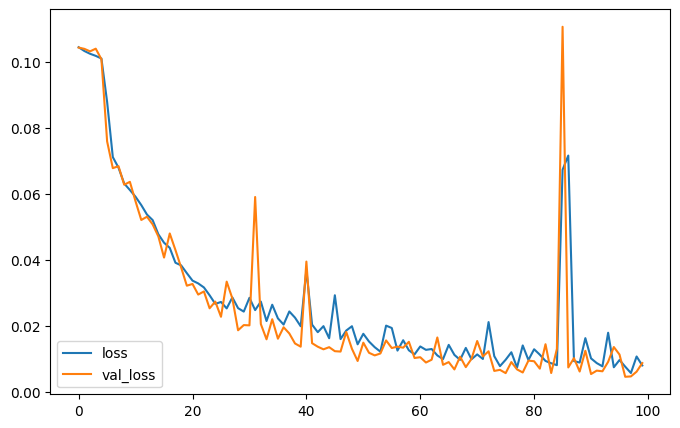

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [ ]:
sensor_subject_folder = 'SA07'
sensor_data_file = 'S07T20R02.csv'

full_sensor_data_path = f'/content/drive/MyDrive/sensor_data/{sensor_subject_folder}/{sensor_data_file}'

sensor_data = pd.read_csv(full_sensor_data_path)
shape = sensor_data.shape

sensor_data.head()

In [ ]:
plt.plot([x for x in range(shape[0])], sensor_data[['AccX']], color='b')
plt.plot([x for x in range(shape[0])], sensor_data[['AccY']], color='r')
plt.plot([x for x in range(shape[0])], sensor_data[['AccZ']], color='g')
plt.show()

In [ ]:
plt.plot([x for x in range(shape[0])], sensor_data[['GyrX']], color='b')
plt.plot([x for x in range(shape[0])], sensor_data[['GyrY']], color='r')
plt.plot([x for x in range(shape[0])], sensor_data[['GyrZ']], color='g')
plt.show()

In [ ]:
plt.plot([x for x in range(shape[0])], sensor_data[['EulerX']], color='b')
plt.plot([x for x in range(shape[0])], sensor_data[['EulerY']], color='r')
plt.plot([x for x in range(shape[0])], sensor_data[['EulerZ']], color='g')
plt.show()

In [ ]:
has_fallen_data = sensor_data.assign(has_fallen=0)

has_fallen_data.loc[(has_fallen_data['FrameCounter'] >= 214) & (has_fallen_data['FrameCounter'] <= 332), 'has_fallen'] = 1

In [ ]:
# flattening data
data = has_fallen_data.iloc[:, 2:]
input_list = data.values
data.shape

In [ ]:
# scaling data
sc = MinMaxScaler()
has_fallen_scaled = sc.fit_transform(input_list)
print(f"Original data range: [{np.min(input_list)}, {np.max(input_list)}]")
print(f"Scaled data range: [{np.min(has_fallen_scaled)}, {np.max(has_fallen_scaled)}]")
input_list.shape, has_fallen_scaled.shape

In [ ]:
x_train = []
y_train = []

for i in range(60, input_list.shape[0]):
  x_train.append(has_fallen_scaled[i-60:i, 0])
  y_train.append(has_fallen_scaled[i, 0])

print(f'x_tain: {len(x_train)}')
print(f'y_tain: {len(y_train)}')

# x_train, y_train = np.array(x_train), np.array(y_train)
x_train, x_test, y_train, y_test = train_test_split(np.array(x_train), np.array(y_train), test_size=0.2)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

In [ ]:
print(model.compiled_metrics)

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()